# Seasonality, stationarity and normalization in Time Series

### Notebook by **David Andrés** 🤖📈🐍 

#### for [💊Machine Learning Pills💊](https://mlpills.dev/)

**Follow me on Twitter**: [@daansan_ml](https://twitter.com/daansan_ml)




---------------

Let's install the libraries we will need and import them

In [1]:
import numpy as np
import pandas as pd 

import datetime

import matplotlib.pyplot as plt

## Import dataset

First we need to import the dataset. 

In this notebook we will work with data about the monthly beer production in Australia.

You can download the dataset by running the following cell:

In [2]:
!wget -P ./dataset --no-check-certificate --content-disposition https://raw.githubusercontent.com/MLPills/missing-values-and-detrending/main/dataset/monthly-beer-production-in-austr.csv

--2023-02-21 13:27:40--  https://raw.githubusercontent.com/MLPills/missing-values-and-detrending/main/dataset/monthly-beer-production-in-austr.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6426 (6.3K) [text/plain]
Saving to: ‘./dataset/monthly-beer-production-in-austr.csv’

monthly-beer-produc 100%[===================>]   6.28K  --.-KB/s    in 0s      

2023-02-21 13:27:40 (80.1 MB/s) - ‘./dataset/monthly-beer-production-in-austr.csv’ saved [6426/6426]



In [3]:
df = pd.read_csv("dataset/monthly-beer-production-in-austr.csv")

### Exploratory Data Analysis

Let's check now how the dataset looks like.

In [4]:
df.head()

,Month,Monthly beer production
0,1956-01,93.2
1,1956-02,96.0
2,1956-03,95.2
3,1956-04,77.1
4,1956-05,70.9


In time series we need the index of the dataframe to be the date.

First, let's double-check that the date is in the right format (datetime).

In [5]:
df.dtypes

Month                       object
Monthly beer production    float64
dtype: object

The `Month` column is not a datetime type. So let's convert it!

In [6]:
df['Month'] = pd.to_datetime(df['Month'], format='%Y-%m')

We can now verify that the changes are correct.

In [7]:
df.dtypes

Month                      datetime64[ns]
Monthly beer production           float64
dtype: object

Let's set the date (`Month`) as the index.

In [8]:
df = df.set_index('Month')

And finally verify that it worked.

In [9]:
df.head()

,Monthly beer production
Month,
1956-01-01,93.2
1956-02-01,96.0
1956-03-01,95.2
1956-04-01,77.1
1956-05-01,70.9


We have it now as we wanted, the index of the dataframe is the date.

Let's also convert the dataframe to series by selecting the only column present. We can do this here because we are in an univariate case.

In [10]:
df_beer = df['Monthly beer production']

It is important that we also visualize the data.

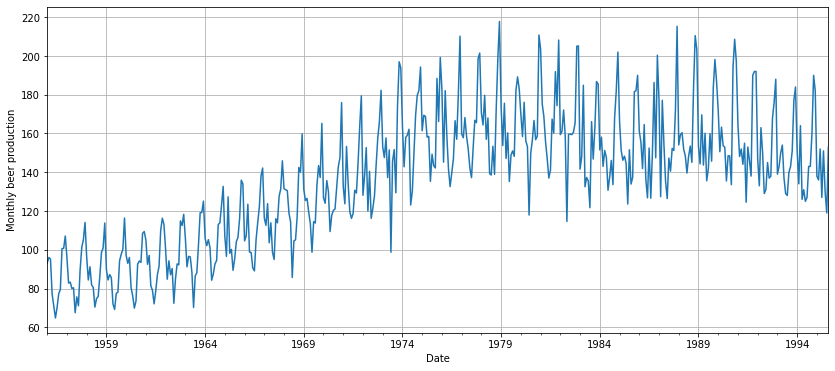

In [11]:
# Import required libraries
import matplotlib.pyplot as plt

# Plot data
df_beer.plot(figsize=(14,6))
plt.xlabel('Date')
plt.ylabel('Monthly beer production')
plt.grid()
plt.show()

Some observations:
* It is non-stationary
* There seems to be a seasonal component
* There is a trend and an increasing variance
* It looks like there are some outliers

### Missing values

We need to check if there are any missing values in the dataframe.

In [12]:
df_beer.isna().sum()

0

Fortunately for us there are not.

If there were you could handle them in some of the following ways.

### Remove the trend

The first step to achieving that is to remove the trend. There are many ways of achieving this, we will use *differencing*.

In [13]:
df_beer = df_beer.diff()

We need to drop the first *NaN* value coming from taking the difference.

In [14]:
df_beer = df_beer.dropna()

We can now see how it looks.

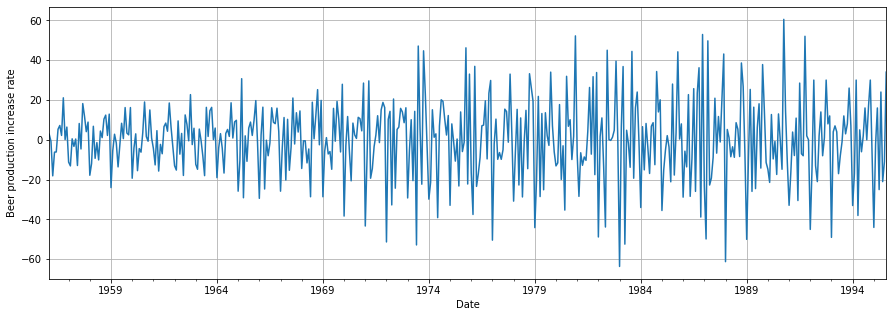

In [15]:
df_beer.plot(figsize=(15,5))
plt.xlabel('Date')
plt.ylabel('Beer production increase rate')
plt.grid()
plt.show()

You can see that now it is centered around zero.

However, we still have increasing volatility, which we need to address to achieve stationarity.

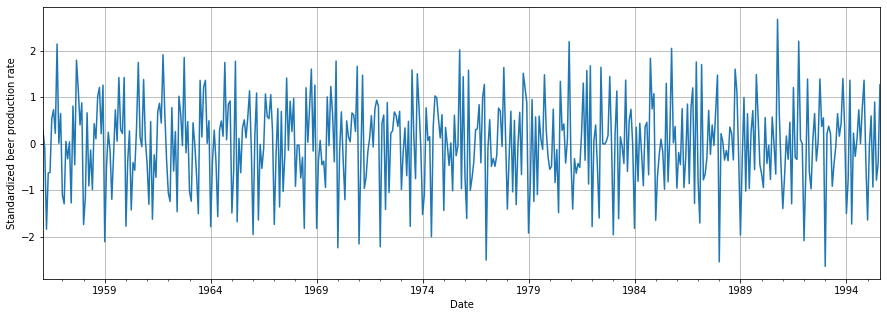

In [16]:
# Calculate each year's variance (equivalent to standard deviation)
annual_variance = df_beer.groupby(df_beer.index.year).std()
mapped_annual_variance = df_beer.index.map(
    lambda x: annual_variance.loc[x.year])

# Standardize each year's variance
df_beer = df_beer / mapped_annual_variance

# Plot outcome
df_beer.plot(figsize=(15,5))
plt.xlabel('Date')
plt.ylabel('Standardized beer production rate')
plt.grid()
plt.show()

### Remove seasonality

Before starting, we could use Python’s statsmodels library to see the seasonal decomposition of the data before we removed the trend. This is not a required step, but it could be useful to visualize the components of the time series data. Before using it, we need to select the seasonality period. We assume there is anual seasonality, so we will set it to 12 (12 months in a year).

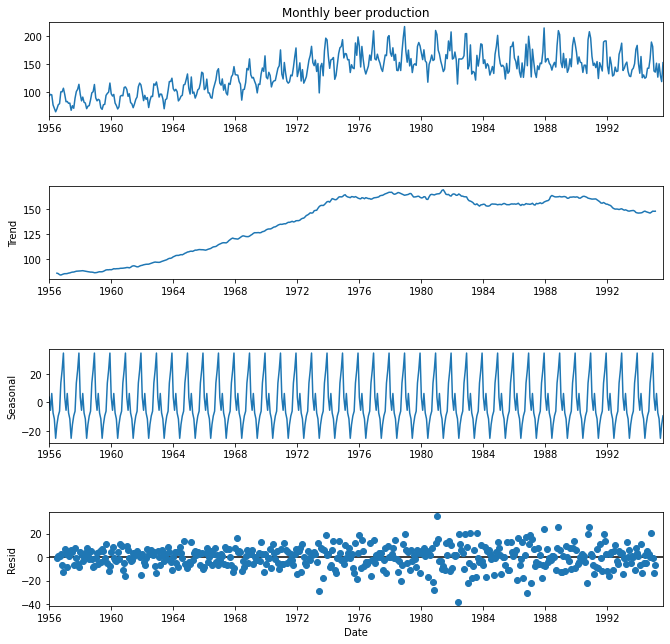

In [30]:
# Import library
import statsmodels.api as sm

# Decompose data by selecting the appropiate frequency
decomp = sm.tsa.seasonal_decompose(
  df['Monthly beer production'], period=12)
decomp_plot = decomp.plot()

# Plot outcome
plt.xlabel('Date')
decomp_plot .set_figheight(10)
decomp_plot .set_figwidth(10)
plt.show()

As expected, we can see one production peak every year and a smooth trend without ups and downs, only the actual trend over the years. We can also see the residuals, which refer to all noise or anomalies during this period of time after extracting the seasonal component and the trend.

We will use a more intuitive approach for removing the seasonality from our data.

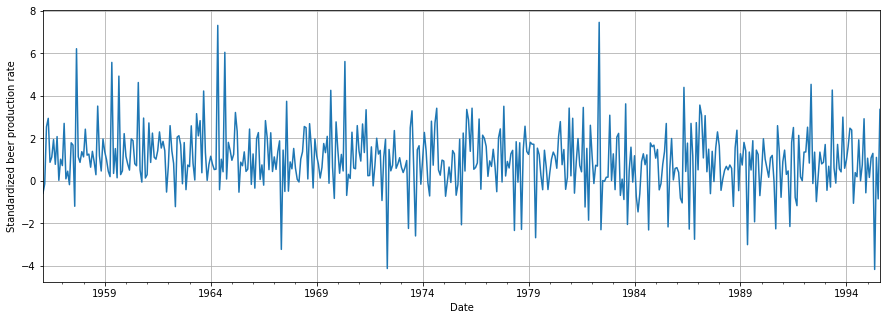

In [22]:
# Calculate each year's variance (equivalent to standard deviation)
monthly_average = df_beer.groupby(df_beer.index.month).mean()
mapped_monthly_average = df_beer.index.map(
    lambda x: monthly_average.loc[x.month])

# Standardize each year's variance
df_beer = df_beer / mapped_monthly_average

# Plot outcome
df_beer.plot(figsize=(15,5))
plt.xlabel('Date')
plt.ylabel('Standardized beer production rate')
plt.grid()
plt.show()

We can see now that the outcome looks pretty random and therefore stationary. We could check if this is actually the case.

### Check for stationarity

Stationarity refers to a property of the data where statistical properties such as the mean, variance, and autocorrelation structure remain constant over time.

We can use the Augmented Dickey-Fuller (ADF) test and the Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test to check for stationarity in a time series:

In [23]:
# Import required libraries
from statsmodels.tsa.stattools import adfuller, kpss

# Perform ADF test
result = adfuller(df_beer)
print('ADF test:\tp-value: {:.3f}'.format(result[1]))

# Perform KPSS test
result = kpss(df_beer)
print('KPSS test:\tp-value: {:.3f}'.format(result[1]))

ADF test:	p-value: 0.001
KPSS test:	p-value: 0.010


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


For the ADF test, we need to check if the p-value is lower than the significance level (often set as 0.05). In this case, it is, so the data is stationary according to this criteria.
For the KPSS test, we need to check if the p-value is greater than the significance level. In this case, it is lower than 0.05, therefore it is not stationary according to this test.

We still need to work on making our data stationary. We can simply apply another differencing and perform both tests again.

In [24]:
# Apply one more differencing to the data
df_beer = df_beer.diff()[1:]

# Perform ADF test
result = adfuller(df_beer)
print('ADF test:\tp-value: {:.3f}'.format(result[1]))

# Perform KPSS test
result = kpss(df_beer)
print('KPSS test:\tp-value: {:.3f}'.format(result[1]))

ADF test:	p-value: 0.000
KPSS test:	p-value: 0.100


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


Now the ADF test p-value is still lower than 0.05 and the KPSS test p-value is greater than 0.05. Therefore we have stationary time series data.

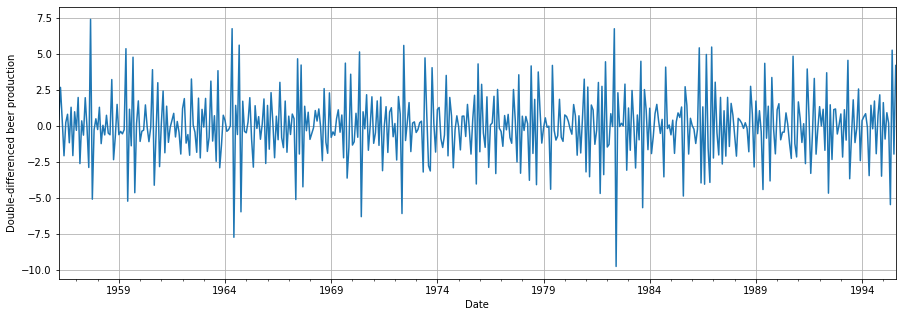

In [26]:
df_beer.plot(figsize=(15,5))
plt.xlabel('Date')
plt.ylabel('Double-differenced beer production')
plt.grid()
plt.show()

### Normalize the data

The next step is to bring the data to a common scale, this is called normalization.

We will use the Standard Scaler, since it will be useful later for removing the outliers. There are two alternatives here: the intuitive approach and the one using the scikit-learn library.

The intuitive approach is very easy and straightforward to implement:

In [27]:
# Calculate mean and standard deviation
mean = df_beer.mean()
std = df_beer.std()

# Normalize data
df_beer = (df_beer - mean) / std

We can also do it with the scikit-learn function:

In [28]:
# Import library
from sklearn.preprocessing import StandardScaler

# Create a StandardScaler object
scaler = StandardScaler()

# Convert data to numpy array and reshape
array_beer = df_beer.values.reshape(-1, 1)

# Fit the scaler to the data and transform it
data_scaled = scaler.fit_transform(array_beer)

# Convert back to pandas Series
df_beer = pd.Series(data_scaled.flatten(), 
                    index=df_beer.index, name='Month')

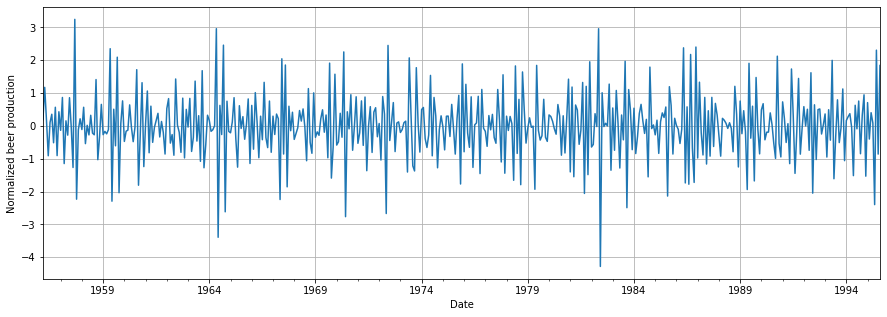

In [29]:
df_beer.plot(figsize=(15,5))
plt.xlabel('Date')
plt.ylabel('Normalized beer production')
plt.grid()
plt.show()

We can finally see how our data is stationary and normalized. We are now a step closer to being able to start building our model!

------

#### [💊Machine Learning Pills💊](https://mlpills.dev/)

**Follow me on Twitter**: [@daansan_ml](https://twitter.com/daansan_ml)

### **David Andrés** 🤖📈🐍 